In [44]:

import os
import sys
import torch
from visual import *
import thinker.util as util
import matplotlib.pyplot as plt
from argparse import Namespace
import json
import csv
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mtick

def ucb(model_stat, K=20):
    q_min, q_max = -1.2, 7
    cur_q = torch.clone(model_stat["cur_qs_mean"])
    cur_q[model_stat["reset"] == 1] = model_stat["root_qs_mean"][
        model_stat["reset"] == 1
    ]
    qsa = (cur_q - q_min) / (q_max - q_min)
    cur_logits = torch.clone(model_stat["cur_logits"])
    cur_logits[model_stat["reset"] == 1] = model_stat["root_logits"][
        model_stat["reset"] == 1
    ]
    psa = torch.nn.functional.softmax(cur_logits, dim=-1)
    cur_ns = torch.clone(model_stat["cur_ns"])
    cur_ns[model_stat["reset"] == 1] = model_stat["root_ns"][model_stat["reset"] == 1]
    nsa = cur_ns * K
    c_1 = 1.25
    c_2 = 19625

    sum_nsa = torch.sum(nsa, dim=-1, keepdim=True)
    l = qsa + psa * (torch.sqrt(sum_nsa)) / (1 + nsa) * (
        c_1 + torch.log((sum_nsa + c_2 + 1) / c_2)
    )
    sel_action = torch.argmax(l, dim=-1)    
    #print(l[0], sel_action[0])
    return sel_action

check_point_path = "/home/schk/RS/thinker/logs/thinker/v13_0.72_mcts_100K_flexq"
check_point_path = "/home/schk/RS/thinker/logs/thinker/v13_0.7b6_dirloss_r3"
check_point_path = "/home/schk/RS/thinker/logs/thinker/v13_0.72_mcts_100K_flexq_nol"
batch_size = 16
max_eps_n = 10
seed = 5
verbose = True

if verbose: batch_size = 1

device = torch.device("cuda")
flags = util.parse(["--load_checkpoint", check_point_path])
flags.tree_carry = False
flags.rec_t = 100
flags.max_depth = -1

env = Environment(flags, env_n=batch_size, model_wrap=True, debug=False, device=device, debug_done=False)
num_actions = env.num_actions
seed = np.arange(batch_size) + seed
env.seed(seed)
model_net = ModelNet(
    obs_shape=env.gym_env_out_shape,
    num_actions=env.num_actions,
    flags=flags,
    debug=True,
)
model_net.train(False)
model_path = os.path.join(check_point_path, "ckp_model.tar")
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(
    checkpoint["model_state_dict"]
    if "model_state_dict" in checkpoint
    else checkpoint["model_net_state_dict"]
)
model_net.to(device)

with torch.no_grad():
    env_out = env.initial(model_net) 
    x = env_out.gym_env_out[0,0].detach().cpu().numpy()
    returns = []
    stat = {"model_stat": [], "action": [], "reward": []}
    n = 0
    cur_rollout = []
    while len(returns) < max_eps_n:
        n += 1
        model_out = util.decode_model_out(
            env_out.model_out, num_actions, flags.model_enc_type
        )

        # real action
        temp = 0.25
        root_ns = torch.clone(model_out["root_ns"]) * flags.rec_t
        n_temp = root_ns ** (1 / temp) + 1e-7
        p = n_temp / torch.sum(n_temp, dim=-1, keepdim=True)        
        #print(cur_t, root_ns[0].detach().cpu().numpy())        
        real_action = torch.multinomial(p, num_samples=1)[:, 0]
        # imagainary action
        ucb_action = ucb(model_out, flags.rec_t)
        # reset action
        cur_ns = torch.clone(model_out["cur_ns"])
        cur_ns[model_out["reset"] == 1] = model_out["root_ns"][
            model_out["reset"] == 1
        ]
        reset = (torch.sum(cur_ns, dim=-1) <= 0).long()
        action = torch.stack([real_action, ucb_action, reset], dim=-1).unsqueeze(0)        

        cur_t = env_out.cur_t[0,0].detach().cpu().item()
        if verbose:
            if cur_t == flags.rec_t - 1: print(cur_t, p[0].detach().cpu().numpy())
            if n % 100 == 0: print("step: %d" % n)
            cur_rollout.append(ucb_action[0].item())
            print(cur_t, ucb_action[0].item(), reset[0].item(),  model_out["cur_r"][0].item()), 
            print("cur_ns:", model_out["cur_ns"][0].detach().cpu().numpy() * flags.rec_t)      

            if reset[0].item() == 1: 
                print("rollout: ", cur_rollout, model_out["root_trail_r"][0].item(), model_out["root_trail_q"][0].item())
                cur_rollout = []
        env_out = env.step(action, model_net)

        if torch.any(env_out.real_done):
            new_rets = (
                env_out.episode_return[env_out.real_done][:, 0].cpu().numpy()
            )
            returns.extend(new_rets)
            print(
                "Finish %d episode: avg. return: %.2f (+-%.2f) "
                % (
                    len(returns),
                    np.average(returns),
                    np.std(returns) / np.sqrt(len(returns)),
                )
            )
        if n > flags.rec_t and verbose: break

0 0 1 0.0
cur_ns: [0. 0. 0. 0. 0.]
rollout:  [0] 0.0 0.33665555715560913
1 0 0 -0.009957033209502697
cur_ns: [0. 0. 0. 0. 0.]
2 0 1 -0.009957033209502697
cur_ns: [0. 0. 0. 0. 0.]
rollout:  [0, 0] -0.009957033209502697 0.29079774022102356
3 4 0 -0.01179620623588562
cur_ns: [0. 0. 0. 0. 0.]
4 0 1 0.12487097829580307
cur_ns: [0. 0. 0. 0. 0.]
rollout:  [4, 0] 0.12487098574638367 0.8847343325614929
5 0 0 -0.012327666394412518
cur_ns: [0. 0. 0. 0. 0.]
6 0 0 -0.009957033209502697
cur_ns: [1. 0. 0. 0. 0.]
7 0 1 -0.01179620623588562
cur_ns: [0. 0. 0. 0. 0.]
rollout:  [0, 0, 0] -0.021399352699518204 0.2402087152004242
8 0 0 -0.012188165448606014
cur_ns: [0. 0. 0. 0. 0.]
9 4 0 -0.009957033209502697
cur_ns: [2. 0. 0. 0. 0.]
10 0 1 0.00911081861704588
cur_ns: [0. 0. 0. 0. 0.]
rollout:  [0, 4, 0] -0.0011195390252396464 0.7415012717247009
11 4 0 -0.012619901448488235
cur_ns: [0. 0. 0. 0. 0.]
12 4 0 0.12487097829580307
cur_ns: [1. 0. 0. 0. 0.]
13 0 1 -0.013547524809837341
cur_ns: [0. 0. 0. 0. 0.]
roll

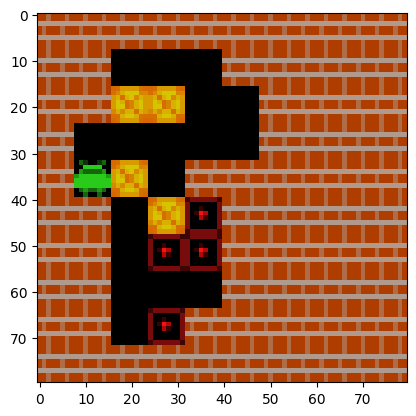

In [24]:
plt.imshow(np.transpose(x, (1, 2, 0)))

In [41]:
check_point_path = "/home/schk/RS/thinker/logs/thinker/v13_0.72_mcts_100K_flexq"
#check_point_path = "/home/schk/RS/thinker/logs/thinker/v13_0.7b6_dirloss_r3"
check_point_path = "/home/schk/RS/thinker/logs/thinker/v13_0.72_mcts_100K_flexq_nol"
batch_size = 1
max_eps_n = 10
seed = 5

device = torch.device("cuda")
flags = util.parse(["--load_checkpoint", check_point_path])
flags.tree_carry = False
flags.rec_t = 5000
flags.max_depth = -1

env = Environment(flags, env_n=batch_size, model_wrap=True, debug=True, device=device, debug_done=False)
num_actions = env.num_actions
seed = np.arange(batch_size) + seed
env.seed(seed)
model_net = ModelNet(
    obs_shape=env.gym_env_out_shape,
    num_actions=env.num_actions,
    flags=flags,
    debug=True,
)
model_net.train(False)
model_path = os.path.join(check_point_path, "ckp_model.tar")
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(
    checkpoint["model_state_dict"]
    if "model_state_dict" in checkpoint
    else checkpoint["model_net_state_dict"]
)
model_net.to(device)

im_actions = [1, 4, 4, 2, 2]
reset_actions = [0, 0, 0, 0, 0]

env_out = env.initial(model_net) 

for im, reset in zip(im_actions, reset_actions):
    action = torch.tensor([0, im, reset], device=device, dtype=torch.long).unsqueeze(0).unsqueeze(0)
    env_out = env.step(action, model_net)
    model_out = util.decode_model_out(
            env_out.model_out, num_actions, flags.model_enc_type
        )
    print(model_out)

{'root_action': tensor([[1., 0., 0., 0., 0.]], device='cuda:0'), 'root_r': tensor([[0.]], device='cuda:0'), 'root_v': tensor([[0.3367]], device='cuda:0'), 'root_logits': tensor([[ 3.0731, -6.4395, -5.1357, -8.1201,  2.3087]], device='cuda:0'), 'root_qs_mean': tensor([[0.0000, 0.2689, 0.0000, 0.0000, 0.0000]], device='cuda:0'), 'root_qs_max': tensor([[0.0000, 0.2689, 0.0000, 0.0000, 0.0000]], device='cuda:0'), 'root_ns': tensor([[0.0000, 0.0002, 0.0000, 0.0000, 0.0000]], device='cuda:0'), 'root_trail_r': tensor([[-0.0104]], device='cuda:0'), 'root_trail_q': tensor([[0.2689]], device='cuda:0'), 'root_max_v': tensor([[0.3367]], device='cuda:0'), 'cur_action': tensor([[0., 1., 0., 0., 0.]], device='cuda:0'), 'cur_r': tensor([[-0.0104]], device='cuda:0'), 'cur_v': tensor([[0.2880]], device='cuda:0'), 'cur_logits': tensor([[ 1.1300, -7.1912,  1.2298, -6.0933,  1.0720]], device='cuda:0'), 'cur_qs_mean': tensor([[0., 0., 0., 0., 0.]], device='cuda:0'), 'cur_qs_max': tensor([[0., 0., 0., 0., 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


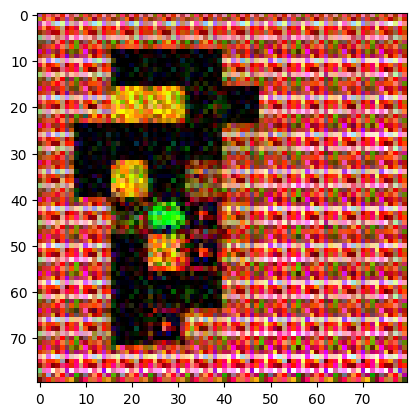

In [42]:
pred_x = env.env.xs[0,0].detach().cpu().numpy()
plt.imshow(np.transpose(pred_x, (1, 2, 0)))

In [5]:
import torch, os
model_path = os.path.join("/home/schk/tmp", "ckp_model.tar")
checkpoint = torch.load(model_path, torch.device("cpu"))
checkpoint["real_step"]

34443200